### RFM Analysis
RFM : Recency(최근 구매), Frequency(자주 구매), Monetary(얼마나 구매)

즉, 사용자의 유형을 3가지 기준에 따라 segmentation하여 각 segment의 유형을 파악하는 분석 기법이다.

In [108]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
from dotenv import load_dotenv
load_dotenv()
MYSQL_ROOT_PW = os.environ.get("MYSQL_ROOT_PW")

In [26]:
con = pymysql.connect(host="localhost", db="ecommerce", user="root", password=MYSQL_ROOT_PW)
cur = con.cursor()

In [60]:
column_dict = {}

cur.execute("SHOW tables;")
for table in [x[0] for x in cur.fetchall()]:
    query = f"SHOW columns from {table};"
    cur.execute(query)
    table_cols = [x[0] for x in cur.fetchall()]
    column_dict[table] = table_cols

In [61]:
# SELECT query의 결과를 dataframe 형태로 return하여 보여주는 함수
# query : SELECT ~ FROM ~ 문

def fetchresult_to_df(query):
    cur.execute(query)
    result = cur.fetchall()
    return pd.DataFrame(result)

In [ ]:
# customer table
# 고객의 ID, 성별, 거주지, 가입 이후 기간 (개월)

try:
    query = """
    SELECT *
    FROM customer;
    """
    df = fetchresult_to_df(query)
    df.columns = column_dict["customer"]
    display(df.head(3))
except:
    print("SQL Server Connection Error!")

,customer_id,gender,city,duration
0,USER_0000,여,New York,31
1,USER_0001,남,New York,20
2,USER_0002,남,California,39


In [65]:
# onlinesales table
# 고객의 ID, 거래 ID, 거래 일시, 상품 ID 등 ...

try:
    query = """
    SELECT *
    FROM onlinesales;
    """
    df = fetchresult_to_df(query)
    df.columns = column_dict["onlinesales"]
    display(df.head(3))
except:
    print("SQL Server Connection Error!")

,customer_id,transaction_id,transaction_date,product_id,category,amount,average_price,shipping_fee,coupon_status
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used


#### 1. Recency : 최근 구매

고객들의 최근 구매일자 분포를 확인하고, 3개의 그룹으로 나누어 각 고객의 특성을 분석한다.

3개의 그룹으로 나눈 이유는 ... 내맘임

In [100]:
# 각 customer_id별로 가장 최근의 거래 일자를 확인
# 2019-01-01 ~ 2019-12-31 범위의 거래가 포착됨 -> 데이터셋은 2019년도의 거래 데이터만을 대상으로 하고 있음을 유추 가능

try:
    query = """
    SELECT customer_id, MAX(transaction_date) last_purchase
    FROM onlinesales
    GROUP BY 1
    ORDER BY 2 DESC;
    """
    df = fetchresult_to_df(query)
    df.columns = ["customer_id", "recent_purchase_date"]
    display(df)
except:
    print("SQL Server Connection Error!")

,customer_id,recent_perchase_date
0,USER_0563,2019-12-31
1,USER_0513,2019-12-31
2,USER_0167,2019-12-31
3,USER_0845,2019-12-31
4,USER_0504,2019-12-31
...,...,...
1463,USER_0922,2019-01-02
1464,USER_1421,2019-01-02
1465,USER_1249,2019-01-02
1466,USER_0954,2019-01-02


In [105]:
# 각 고객들의 last_purchase date의 월별 분포
# 가장 최근의 구매가 발생한 '월'을 집계하는 쿼리이므로, 1월에서 12월로 갈수록 recent_purchase_date가 커지는 모습
# 그러나, 12월로 갈수록 커지는 거시적인 경향성과 다르게, 1월(2월, 3월에 비해 매우 높은 수치) 의 수치가 두드러진다.abs
# => 1월달에 일회성 구매를 유발하는 마케팅이 발생하지 않았을까?

try:
    query = """
    WITH LAST_PURCHASE AS (
    SELECT customer_id, MAX(transaction_date) last_purchase
    FROM onlinesales
    GROUP BY 1
    ORDER BY 2 DESC)

    SELECT MONTH(last_purchase), count(*)
    FROM LAST_PURCHASE
    GROUP BY 1
    ORDER BY 1;
    """
    df_last = fetchresult_to_df(query)
    df_last.columns = ["month", "recent_purchase_date"]
    display(df_last)
except:
    print("SQL Server Connection Error!")

,month,recent_purchase_date
0,1,96
1,2,31
2,3,74
3,4,99
4,5,83
5,6,118
6,7,113
7,8,166
8,9,138
9,10,154


In [106]:
# 월별 마케팅 비용의 지출을 확인한 결과, 1월달 마케팅 비용의 지출이 큰 것을 확인할 수 있었다.

try:
    query = """
    SELECT
        MONTH(marketing_date), 
        sum(offline_expense), 
        sum(online_expense),
        sum(offline_expense) + sum(online_expense)
    FROM marketing
    GROUP BY 1
    ORDER BY 1;
    """
    df_mark = fetchresult_to_df(query)
    df_mark.columns = ["month", "offline_expense", "online_expense", "all_marketing_expense"]
    display(df_mark)
except:
    print("SQL Server Connection Error!")

,month,offline_expense,online_expense,all_marketing_expense
0,1,96600.0,58328.950226,154928.950226
1,2,81300.0,55807.920105,137107.920105
2,3,73500.0,48750.090454,122250.090454
3,4,96000.0,61026.829773,157026.829773
4,5,65500.0,52759.640045,118259.640045
5,6,80500.0,53818.139832,134318.139832
6,7,67500.0,52717.850128,120217.850128
7,8,85500.0,57404.150635,142904.150635
8,9,83000.0,52514.540222,135514.540222
9,10,93500.0,57724.650024,151224.650024


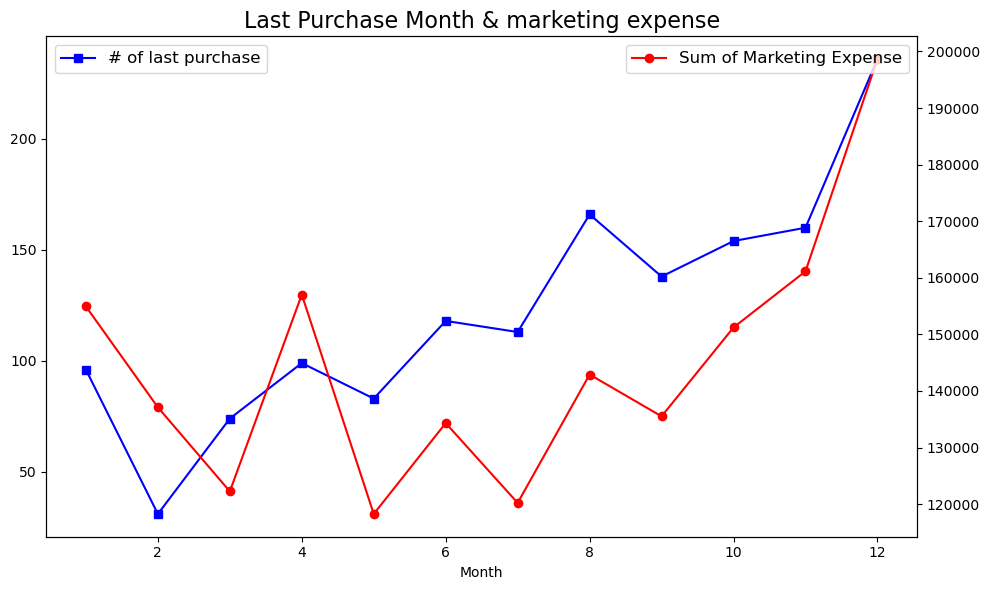

In [ ]:
# 실제로 두 값을 plot을 그려 비교하면 그 경향성은 더욱 명확해진다.
# 마케팅 비용 지출이 컸던 1월에 last purchase가 많이 발생한 모습이다. (처음이자 마지막 구매일 가능성이 높다!)

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_title('Last Purchase Month & marketing expense', fontsize=16)
ax1.set_xlabel('Month')
ax1.plot(df_last["month"], df_last["recent_purchase_date"], marker='s', color="blue")
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.plot(df_mark["month"], df_mark["all_marketing_expense"], marker='o', color="red")
ax2.tick_params(axis='y')

ax1.legend(['# of last purchase'], fontsize=12, loc=0)
ax2.legend(['Sum of Marketing Expense'], fontsize=12, loc=1)
fig.tight_layout()
plt.show()

In [95]:
# 각 구매자의 구매횟수를 백분위수(PERCENT_RANK())로 나타낸 결과

try:
    query = """
    WITH cus_trans_count as (
    SELECT customer_id, count(*) count
    FROM onlinesales
    GROUP BY 1
    ORDER BY 2 desc)

    SELECT *, ROUND(PERCENT_RANK() OVER(ORDER BY count DESC), 3) PER
    FROM cus_trans_count
    ORDER BY 3;
    """
    df = fetchresult_to_df(query)
    df.columns = ["customer_id", "count", "percent_rank"]
    display(df.head(3))
except:
    print("SQL Server Connection Error!")

,customer_id,count,percent_rank
0,USER_0118,695,0.000
1,USER_0736,587,0.001
2,USER_0563,575,0.001


In [ ]:
try:
    query = """
    WITH cus_trans_count as (
    SELECT customer_id, count(*) count
    FROM onlinesales
    GROUP BY 1
    ORDER BY 2 desc)

    SELECT *, ROUND(PERCENT_RANK() OVER(ORDER BY count DESC), 3) PER
    FROM cus_trans_count
    ORDER BY 3;
    """
    df = fetchresult_to_df(query)
    df.columns = ["customer_id", "count", "percent_rank"]
    display(df.head(3))
except:
    print("SQL Server Connection Error!")